In [1]:
import numpy as np
import pandas as pd
import gc
import warnings
warnings.filterwarnings('ignore')
import os
import glob
import os.path as osp
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils import data as D
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import cv2
from tqdm import tqdm
import zipfile 
import time
import random as rnd
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torchvision.transforms import functional as TF
from torchvision.utils import make_grid,save_image
from torchvision.datasets import ImageFolder,DatasetFolder
from torch.autograd import Variable
from torchvision.transforms import InterpolationMode
from numpy.random import choice
from numpy.random import seed as np_seed

In [2]:
import re
def numericalSort(value):
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

bottleneck = 4000
image_size = 256

In [3]:
class Data(D.Dataset):
    def __init__(self, path_mask, path_gt, start_ind = 0, end_ind = 5000):
        super(Data, self).__init__()
        self.masked = []
        self.gt = []
        self.path_mask = path_mask
        self.path_gt = path_gt
        self.transform = transforms.Compose([transforms.ToTensor()])
        files_mask = sorted(glob.glob(os.path.join(path_mask, '*.jpg')), key=numericalSort)[start_ind:end_ind]
        files_gt = sorted(glob.glob(os.path.join(path_gt, '*.jpg')), key = numericalSort)[start_ind:end_ind]
        for mask, gt in  zip(files_mask, files_gt):
            self.masked.append(mask)
            self.gt.append(gt)
        self.len = len(self.masked)
        
    def __getitem__(self, index):
        img_masked = Image.open(self.masked[index])
        img_gt = Image.open(self.gt[index])
        return self.transform(img_masked), self.transform(img_gt)
    
    def __len__(self):
        return self.len
        

In [4]:
path_mask = '/home/sghosal/Project/Image_Inpainting/data_places_mask/'
path_gt = '/home/sghosal/Project/Image_Inpainting/data_places_gt/'
train_imgs = Data(path_mask, path_gt)
val_imgs = Data(path_mask, path_gt, 5000, 7000)

torch.Size([3, 256, 256])


tensor(1.)

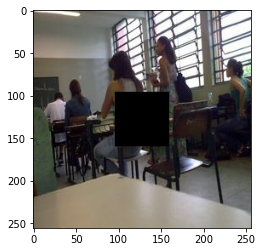

In [5]:
def imshow(img):
    img = img.transpose(0,2).transpose(0,1).numpy()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # Checking that I acutally have the pics associated
# i = np.random.randint(0,len(imgs))
sample = train_imgs[0]
x, y = sample
print(x.shape)
imshow(x)
torch.max(x)

In [6]:
train_loader = D.DataLoader(train_imgs, batch_size = 32, shuffle = True, num_workers = 0)
val_loader = D.DataLoader(val_imgs, batch_size = 32, shuffle = False, num_workers = 0)

In [7]:
class ResBlock(nn.Module):
    def __init__(self, in_channel, out_channel, kernel, stride = 1, padding = 2, downsample = False, batch_norm = False):
        super(ResBlock, self).__init__()
        self.conv_1 = nn.Conv2d(in_channel, out_channel, kernel , stride, padding)
        nn.init.kaiming_normal_(self.conv_1.weight)
        self.conv_2 = nn.Conv2d(out_channel, out_channel, kernel , stride=1, padding=1)
        nn.init.kaiming_normal_(self.conv_2.weight)
        self.relu = nn.ReLU()
        self.BN1 = nn.GroupNorm(out_channel//8, out_channel)
        self.BN2 = nn.GroupNorm(out_channel//8, out_channel)
        if downsample :
            if batch_norm:
                self.shortcut = nn.Sequential(nn.Conv2d(in_channel, out_channel, 1, stride = 2), 
                                              nn.GroupNorm(out_channel//8, out_channel))
            else:
                self.shortcut = nn.Sequential(nn.Conv2d(in_channel, out_channel, 1, stride = 2))
        elif in_channel != out_channel:
            if batch_norm:
                self.shortcut = nn.Sequential(nn.Conv2d(in_channel, out_channel,kernel,stride,padding), 
                                          nn.GroupNorm(out_channel//8, out_channel))
            else:
                self.shortcut = nn.Sequential(nn.Conv2d(in_channel, out_channel,kernel,stride,padding))
                
        else:
            if batch_norm:
                self.shortcut = nn.Sequential(nn.GroupNorm(in_channel//8, in_channel))
            else:
                self.shortcut = nn.Sequential()
                
        if batch_norm:
            self.res_block = nn.Sequential(self.conv_1, self.BN1, self.relu, self.conv_2, self.BN2, self.relu)
        else:
            self.res_block = nn.Sequential(self.conv_1,  self.relu, self.conv_2,  self.relu)
        
    def forward(self, x):
        output = self.res_block(x)
#         print(f'output shape : {output.shape}')
#         print(f'shortcut shape : {output.shape}')
        return output + self.relu(self.shortcut(x))

class Generator(nn.Module):
    def __init__(self,bottleneck, batch_norm = True):
        super(Generator, self).__init__()
        
        self.conv_1 = nn.Conv2d(3, 64, 7, stride = 2, padding = 3)
        nn.init.kaiming_normal_(self.conv_1.weight)
        self.max_pool_1 = nn.MaxPool2d(2, 2)
        self.conv_2x = ResBlock(64,64,kernel=3, stride=2,padding=1, batch_norm = batch_norm, downsample = True)
        self.conv_3x = ResBlock(64,128,kernel=3,stride=1,padding=1, batch_norm= batch_norm)
        self.conv_4x = ResBlock(128,256,kernel=3,stride=2,padding=1, batch_norm= batch_norm, downsample = True)
        self.conv_5x = ResBlock(256,512,kernel=3,stride=2,padding=1, batch_norm= batch_norm, downsample=True)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2,2)
        
        # input: 4 * 4 * 512
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512,bottleneck,kernel_size=(4,4)), 
            nn.BatchNorm2d(bottleneck),
            nn.ReLU()
        )
        
        if batch_norm:
            self.encoder = nn.Sequential(self.conv_1, self.max_pool_1, nn.GroupNorm(8,64) ,self.relu, self.conv_2x, 
                                      self.conv_3x, self.conv_4x, self.conv_5x, self.maxpool, self.bottleneck)
        else:
            self.encoder = nn.Sequential(self.conv_1, self.max_pool_1,self.relu, self.conv_2x, 
                                      self.conv_3x, self.conv_4x, self.conv_5x, self.maxpool, self.bottleneck)
        # current state: 1 * 1 * bottleneck
        
        # Decoder
        self.decoder_layer_1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=bottleneck,out_channels=512,kernel_size=(4,4)),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        # Input: 4 * 4 * 512
        self.decoder_layer_2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        # Input: 8 * 8 * 256
        self.decoder_layer_3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        # Input: 16 * 16 * 128
        self.decoder_layer_4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        # Input: 32 * 32 * 64
        self.decoder_layer_5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64,out_channels=3,kernel_size=(4,4),stride=2,padding=1),
            nn.Tanh()
        )
        # Output: 64 * 64 * 3

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder_layer_1(x)
        x = self.decoder_layer_2(x)
        x = self.decoder_layer_3(x)
        x = self.decoder_layer_4(x)
        x = self.decoder_layer_5(x)

        return x

In [8]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
dev = device

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Input: 64 * 64 * 3
        self.disc_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
            nn.LeakyReLU(0.2,True)
        )
        # Input: 32 * 32 * 64
        self.disc_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,True)
        )
        # Input: 16 * 16 * 128
        self.disc_layer_3 = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,True)
        )
        # Input: 8 * 8 * 256
        self.disc_layer_4 = nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,True)
        )
        # Input: 4 * 4 * 512
        self.disc_layer_5 = nn.Sequential(
            nn.Conv2d(in_channels=512,out_channels=1,kernel_size=(4,4),stride=1,padding=0),
            nn.Sigmoid()
        )
        # Output: 1 * 1 * 1
    
    def forward(self,x):
        x = self.disc_layer_1(x)
        x = self.disc_layer_2(x)
        x = self.disc_layer_3(x)
        x = self.disc_layer_4(x)
        x = self.disc_layer_5(x)
        x = x.view(-1)
        return x

In [10]:
# Import all needed modules

In [11]:
cudnn.benchmark = False 

# Enable cuda if available
if torch.cuda.is_available():
  Tensor = torch.cuda.FloatTensor
  device = 'cuda'
else :
  Tensor = torch.FloatTensor
  device = 'cpu'


# Number of channel RGB 3
channel = 3 

# Imgage size will be C*256*256
img_size = 256

# Mask size it's the size of center mask Cx64x64
mask_size = 64

# Number of pixels overlapped
overlapPred = 0

# Size of batches
batch_size = 32

#  the lower is res value, the more continuous the output will be.
## Value to generate a random patter of 1 and 0 to create a random region
res = 0.06
density = 0.25
MAX_SIZE = 10000

# Paths 
save_path_discriminator = "./gan/checkpoint_discriminator_2.pth"
save_path_generator = "./gan/checkpoint_generator_2.pth"

# Restore backups
restore = False


In [13]:
def imshow_again(img):
    img = img.transpose(0,2).transpose(0,1).numpy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

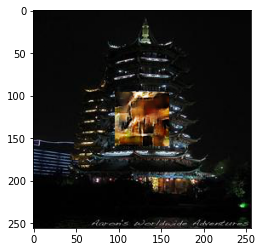

In [18]:
model = Generator(4000)
device = ('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.load_state_dict(torch.load('./models/GAN_ResNet/generator.pt'))
# model.load_state_dict(checkpoint['g_state_dict'])
count = 0
model.eval()
# with torch.no_grad():
for i,(x,y) in enumerate(val_loader):
    if i == 5:
        break
    test = x
    gt = y
    out2 = model(x.to(device))
    for j in range(32):
        x[j][:,96:160,96:160] = out2[j]
        img = imshow_again(x[j].detach())
        plt.imshow(img)
        plt.savefig(f'./results/gan_resnet/gan_resnet_batch_{i}_{j}.png', bbox_inches = 'tight')

In [15]:
model.eval()
with torch.no_grad():
    acc_val = []
    for i,(x,y) in tqdm(enumerate(val_loader)):
        test = x
        gt = y
        out2 = model(x.to(device))
        for j in range(len(x)):
            x[j][:,96:160,96:160] = out2[j]
            loss = (x[:,:,96:160,96:160] - y[:,:,96:160,96:160]) ** 2 
            loss = torch.sum(loss)/32
            acc_val.append(loss)
            
with torch.no_grad():
    acc_train = []
    for i,(x,y) in tqdm(enumerate(train_loader)):
        test = x
        gt = y
        out2 = model(x.to(device))
        for j in range(len(x)):
            x[j][:,96:160,96:160] = out2[j]
            loss = (x[:,:,96:160,96:160] - y[:,:,96:160,96:160]) ** 2 
            loss = torch.sum(loss)/32
            acc_train.append(loss)

63it [02:22,  2.25s/it]
157it [05:54,  2.26s/it]


In [33]:
sum(acc_val)/len(acc_val)

tensor(4704.2788)

In [34]:
sum(acc_train)/len(acc_train)

tensor(4744.8774)